In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import time

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download training dataset
def trainload(batch_size_train):
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', train = True, download = True, 
                                    transform = torchvision.transforms.Compose([
                                        torchvision.transforms.ToTensor(),
                                        torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                    ])), batch_size = batch_size_train, shuffle = True
    )
    return train_loader

In [4]:
# Download test dataset
def testload(batch_size_test):
    test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', train = False, download = True, 
                                    transform = torchvision.transforms.Compose([
                                        torchvision.transforms.ToTensor(),
                                        torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                    ])), batch_size = batch_size_test, shuffle = True
    )
    return test_loader

# 1. Create a CNN model

In [5]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define 1st layer
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels = 1,
                out_channels = 16,
                kernel_size = 5,
                stride = 1,
                padding= 2,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2),            
        )
        
        # Define 2nd layer
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels = 16,
                out_channels = 32,
                kernel_size = 5,
                stride = 1,
                padding= 2,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2),            
        )
        
        # Define a fully connected layer with 10 classes
        self.fc1 = torch.nn.Linear(32 * 7 * 7, 50)
        
        # Define a fully connected layer with 10 neurons
        self.fc2 = torch.nn.Linear(50, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # Flatten the output 
        x = x.view(x.size(0), -1)
        x = torch.nn.functional.relu(self.fc1(x))
        #x = x.view(x.size(0), -1)
        output = self.fc2(x)
        output = torch.nn.functional.log_softmax(output, dim=1)
        return output, x

# 2. Train the CNN model

In [6]:
# Train your model                
def train(num_epochs, cnn, train_loader, test_loader, mini_batch):
    total_train_time = 0
    total_step = len(train_loader)
    train_loss, test_accuracy = [], []
    count = 0
    for epoch in range(num_epochs):
        start = time.time()
        cnn.train()
        total_train_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            images = torch.autograd.Variable(images)
            labels = torch.autograd.Variable(labels)
            count += images.size(0)
            if device.type == "cuda":
                images, labels = images.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            pred = cnn(images)[0]
            
            loss = loss_func(pred, labels)
            
            # Do not optimize for epoch 0
            if epoch > 0:
                loss.backward()
                optimizer.step()
            # Track the loss
            total_train_loss += loss.item()
            if count % 2000 == 0:
                print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(epoch+1, num_epochs, i+1, total_step, loss.item()))
                train_loss.append(total_train_loss/(i+1))
        epoch_train_time = time.time() - start
        total_train_time += epoch_train_time
        print("Epoch Train Time: {:.2f} secs".format(epoch_train_time))
        test_accuracy = test(cnn, test_loader, test_accuracy)
    plot_model(train_loss, test_accuracy)
    print("Total Train Time: {:.2f} mins".format(total_train_time/60))
    
# Track the test accuracy
def test(cnn, test_loader, test_accuracy):
    cnn.eval()
    accuracy = 0
    count = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            count += images.size(0)
            if device.type == "cuda":
                images, labels = images.to("cuda"), labels.to("cuda")
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            if count % 2000 == 0:
                test_accuracy.append(accuracy * 100.0)
    return test_accuracy

# Plot the traning loss and testing accuracy
def plot_model(train_loss, test_accuracy):
    plt.figure(1, figsize=(15, 8))
    plt.plot(train_loss, label = "Training Loss", linewidth = 2.5)
    plt.ylabel("Cross Entropy Loss")
    plt.grid()
    plt.legend()
    plt.figure(2)
    plt.figure(figsize=(15,8))
    plt.plot(test_accuracy, label = "Testing Accuracy", linewidth = 2.5)
    plt.ylabel("Testing Accuracy in %")
    plt.grid()
    plt.legend()

Epoch [1/10], Step [40/1200], Loss: 2.3267
Epoch [1/10], Step [80/1200], Loss: 2.3176
Epoch [1/10], Step [120/1200], Loss: 2.3132
Epoch [1/10], Step [160/1200], Loss: 2.3114
Epoch [1/10], Step [200/1200], Loss: 2.2931
Epoch [1/10], Step [240/1200], Loss: 2.2978
Epoch [1/10], Step [280/1200], Loss: 2.2908
Epoch [1/10], Step [320/1200], Loss: 2.3056
Epoch [1/10], Step [360/1200], Loss: 2.3231
Epoch [1/10], Step [400/1200], Loss: 2.3066
Epoch [1/10], Step [440/1200], Loss: 2.3233
Epoch [1/10], Step [480/1200], Loss: 2.2934
Epoch [1/10], Step [520/1200], Loss: 2.2978
Epoch [1/10], Step [560/1200], Loss: 2.3093
Epoch [1/10], Step [600/1200], Loss: 2.3293
Epoch [1/10], Step [640/1200], Loss: 2.3044
Epoch [1/10], Step [680/1200], Loss: 2.3041
Epoch [1/10], Step [720/1200], Loss: 2.3041
Epoch [1/10], Step [760/1200], Loss: 2.2988
Epoch [1/10], Step [800/1200], Loss: 2.3348
Epoch [1/10], Step [840/1200], Loss: 2.3036
Epoch [1/10], Step [880/1200], Loss: 2.3021
Epoch [1/10], Step [920/1200], Los

Epoch [7/10], Step [120/1200], Loss: 0.0333
Epoch [7/10], Step [160/1200], Loss: 0.1226
Epoch [7/10], Step [200/1200], Loss: 0.0301
Epoch [7/10], Step [240/1200], Loss: 0.0212
Epoch [7/10], Step [280/1200], Loss: 0.0138
Epoch [7/10], Step [320/1200], Loss: 0.0411
Epoch [7/10], Step [360/1200], Loss: 0.0570
Epoch [7/10], Step [400/1200], Loss: 0.1108
Epoch [7/10], Step [440/1200], Loss: 0.0223
Epoch [7/10], Step [480/1200], Loss: 0.0218
Epoch [7/10], Step [520/1200], Loss: 0.1635
Epoch [7/10], Step [560/1200], Loss: 0.0161
Epoch [7/10], Step [600/1200], Loss: 0.0057
Epoch [7/10], Step [640/1200], Loss: 0.1527
Epoch [7/10], Step [680/1200], Loss: 0.0890
Epoch [7/10], Step [720/1200], Loss: 0.0109
Epoch [7/10], Step [760/1200], Loss: 0.1979
Epoch [7/10], Step [800/1200], Loss: 0.0565
Epoch [7/10], Step [840/1200], Loss: 0.0490
Epoch [7/10], Step [880/1200], Loss: 0.0268
Epoch [7/10], Step [920/1200], Loss: 0.0899
Epoch [7/10], Step [960/1200], Loss: 0.0121
Epoch [7/10], Step [1000/1200], 

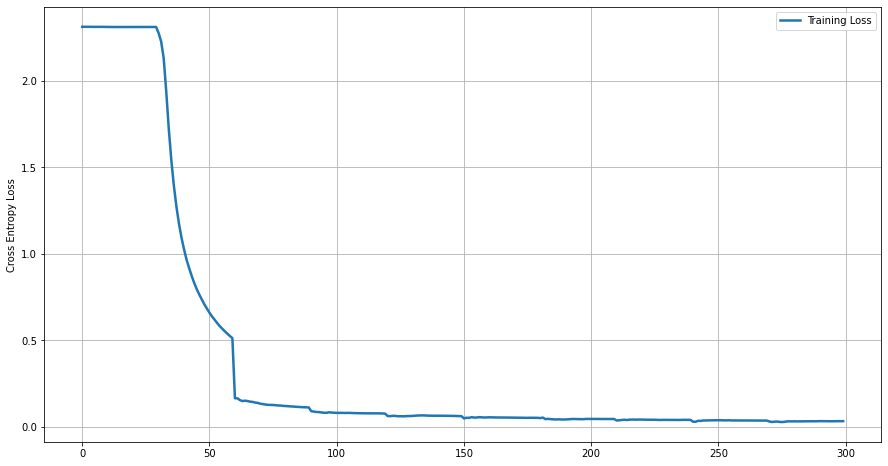

<Figure size 432x288 with 0 Axes>

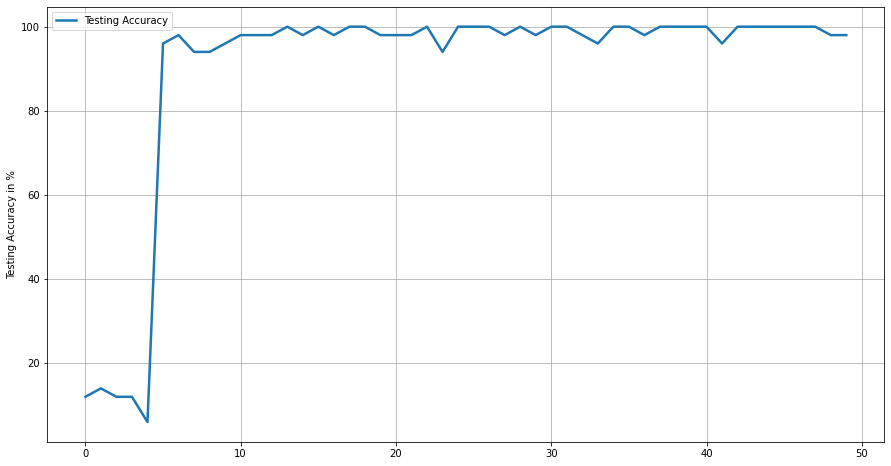

In [7]:
# Download the training and testing data
mini_batch = 50
train_loader = trainload(mini_batch)
test_loader = testload(mini_batch)

# Initialize model
cnn1 = CNN()
if device.type == "cuda":
    cnn1.to('cuda')

# Define loss function
loss_func = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.SGD(cnn1.parameters(), lr = 0.01)

# Train the model
num_epochs = 10
train(num_epochs, cnn1, train_loader, test_loader, mini_batch)

# 3. Train the CNN model by changing the optimzation algorithm

## a) SGD with momentum

Epoch [1/10], Step [40/1200], Loss: 2.2902
Epoch [1/10], Step [80/1200], Loss: 2.3016
Epoch [1/10], Step [120/1200], Loss: 2.2954
Epoch [1/10], Step [160/1200], Loss: 2.3088
Epoch [1/10], Step [200/1200], Loss: 2.2798
Epoch [1/10], Step [240/1200], Loss: 2.3248
Epoch [1/10], Step [280/1200], Loss: 2.2975
Epoch [1/10], Step [320/1200], Loss: 2.3171
Epoch [1/10], Step [360/1200], Loss: 2.3012
Epoch [1/10], Step [400/1200], Loss: 2.3202
Epoch [1/10], Step [440/1200], Loss: 2.2909
Epoch [1/10], Step [480/1200], Loss: 2.3002
Epoch [1/10], Step [520/1200], Loss: 2.3130
Epoch [1/10], Step [560/1200], Loss: 2.3035
Epoch [1/10], Step [600/1200], Loss: 2.3109
Epoch [1/10], Step [640/1200], Loss: 2.3390
Epoch [1/10], Step [680/1200], Loss: 2.2738
Epoch [1/10], Step [720/1200], Loss: 2.2875
Epoch [1/10], Step [760/1200], Loss: 2.3137
Epoch [1/10], Step [800/1200], Loss: 2.3077
Epoch [1/10], Step [840/1200], Loss: 2.2817
Epoch [1/10], Step [880/1200], Loss: 2.3205
Epoch [1/10], Step [920/1200], Los

Epoch [7/10], Step [120/1200], Loss: 0.0191
Epoch [7/10], Step [160/1200], Loss: 0.0284
Epoch [7/10], Step [200/1200], Loss: 0.1270
Epoch [7/10], Step [240/1200], Loss: 0.0622
Epoch [7/10], Step [280/1200], Loss: 0.0158
Epoch [7/10], Step [320/1200], Loss: 0.0159
Epoch [7/10], Step [360/1200], Loss: 0.0335
Epoch [7/10], Step [400/1200], Loss: 0.0051
Epoch [7/10], Step [440/1200], Loss: 0.0141
Epoch [7/10], Step [480/1200], Loss: 0.0058
Epoch [7/10], Step [520/1200], Loss: 0.0527
Epoch [7/10], Step [560/1200], Loss: 0.0473
Epoch [7/10], Step [600/1200], Loss: 0.0053
Epoch [7/10], Step [640/1200], Loss: 0.0283
Epoch [7/10], Step [680/1200], Loss: 0.0240
Epoch [7/10], Step [720/1200], Loss: 0.0112
Epoch [7/10], Step [760/1200], Loss: 0.0016
Epoch [7/10], Step [800/1200], Loss: 0.0148
Epoch [7/10], Step [840/1200], Loss: 0.0119
Epoch [7/10], Step [880/1200], Loss: 0.0047
Epoch [7/10], Step [920/1200], Loss: 0.0393
Epoch [7/10], Step [960/1200], Loss: 0.0332
Epoch [7/10], Step [1000/1200], 

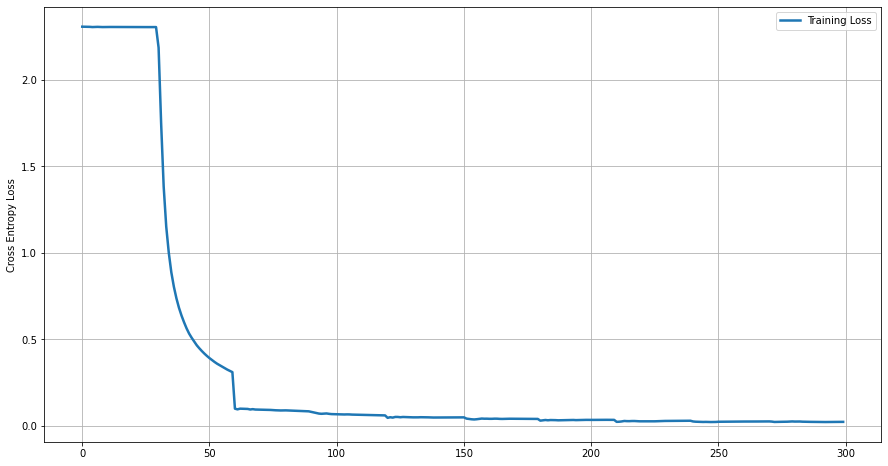

<Figure size 432x288 with 0 Axes>

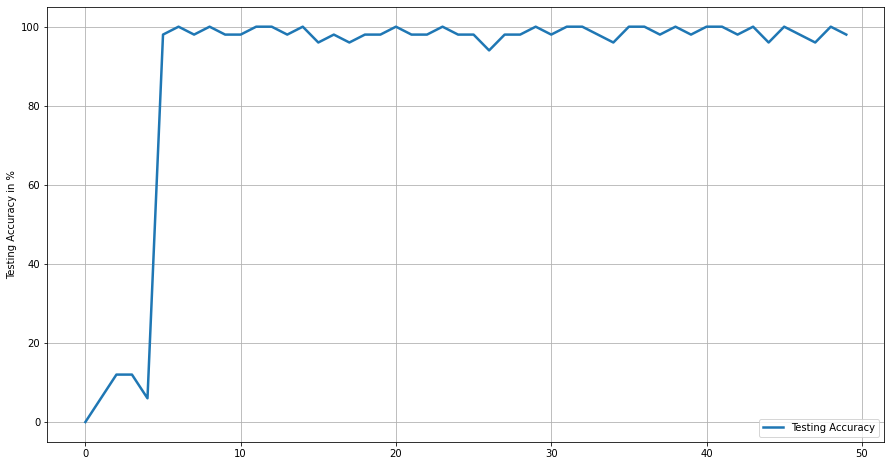

In [8]:
# Download the training and testing data
mini_batch = 50
train_loader = trainload(mini_batch)
test_loader = testload(mini_batch)

# Initialize model
cnn2 = CNN()
if device.type == "cuda":
    cnn2.to('cuda')

# Define loss function
loss_func = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.SGD(cnn2.parameters(), lr = 0.01, momentum = 0.5)

# Train the model
num_epochs = 10
train(num_epochs, cnn2, train_loader, test_loader, mini_batch)

## b) RMSProp optimizer

Epoch [1/10], Step [40/1200], Loss: 2.3002
Epoch [1/10], Step [80/1200], Loss: 2.2928
Epoch [1/10], Step [120/1200], Loss: 2.3035
Epoch [1/10], Step [160/1200], Loss: 2.2897
Epoch [1/10], Step [200/1200], Loss: 2.3078
Epoch [1/10], Step [240/1200], Loss: 2.2966
Epoch [1/10], Step [280/1200], Loss: 2.3006
Epoch [1/10], Step [320/1200], Loss: 2.2932
Epoch [1/10], Step [360/1200], Loss: 2.3028
Epoch [1/10], Step [400/1200], Loss: 2.2932
Epoch [1/10], Step [440/1200], Loss: 2.3092
Epoch [1/10], Step [480/1200], Loss: 2.2951
Epoch [1/10], Step [520/1200], Loss: 2.3080
Epoch [1/10], Step [560/1200], Loss: 2.2938
Epoch [1/10], Step [600/1200], Loss: 2.3029
Epoch [1/10], Step [640/1200], Loss: 2.3086
Epoch [1/10], Step [680/1200], Loss: 2.2982
Epoch [1/10], Step [720/1200], Loss: 2.2970
Epoch [1/10], Step [760/1200], Loss: 2.3092
Epoch [1/10], Step [800/1200], Loss: 2.2883
Epoch [1/10], Step [840/1200], Loss: 2.2965
Epoch [1/10], Step [880/1200], Loss: 2.2961
Epoch [1/10], Step [920/1200], Los

Epoch [7/10], Step [120/1200], Loss: 0.0326
Epoch [7/10], Step [160/1200], Loss: 0.0968
Epoch [7/10], Step [200/1200], Loss: 0.1081
Epoch [7/10], Step [240/1200], Loss: 0.0662
Epoch [7/10], Step [280/1200], Loss: 0.0162
Epoch [7/10], Step [320/1200], Loss: 0.1000
Epoch [7/10], Step [360/1200], Loss: 0.6169
Epoch [7/10], Step [400/1200], Loss: 0.0190
Epoch [7/10], Step [440/1200], Loss: 0.0963
Epoch [7/10], Step [480/1200], Loss: 0.0402
Epoch [7/10], Step [520/1200], Loss: 0.0271
Epoch [7/10], Step [560/1200], Loss: 0.3075
Epoch [7/10], Step [600/1200], Loss: 0.0031
Epoch [7/10], Step [640/1200], Loss: 0.2724
Epoch [7/10], Step [680/1200], Loss: 0.0213
Epoch [7/10], Step [720/1200], Loss: 0.0640
Epoch [7/10], Step [760/1200], Loss: 0.0442
Epoch [7/10], Step [800/1200], Loss: 0.3663
Epoch [7/10], Step [840/1200], Loss: 0.0075
Epoch [7/10], Step [880/1200], Loss: 0.0560
Epoch [7/10], Step [920/1200], Loss: 0.1869
Epoch [7/10], Step [960/1200], Loss: 0.3236
Epoch [7/10], Step [1000/1200], 

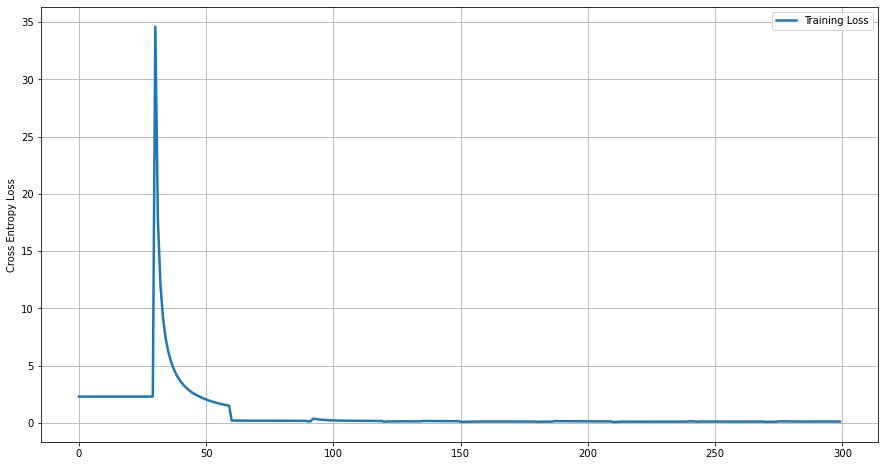

<Figure size 432x288 with 0 Axes>

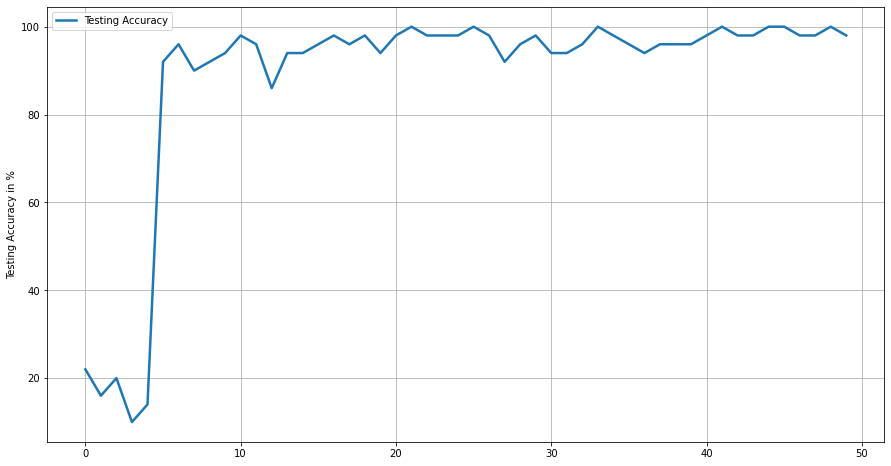

In [9]:
# Download the training and testing data
mini_batch = 50
train_loader = trainload(mini_batch)
test_loader = testload(mini_batch)

# Initialize model
cnn3 = CNN()
if device.type == "cuda":
    cnn3.to('cuda')

# Define loss function
loss_func = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.RMSprop(cnn3.parameters(), lr = 0.01)

# Train the model
num_epochs = 10
train(num_epochs, cnn3, train_loader, test_loader, mini_batch)

## c) Adam optimizer

Epoch [1/10], Step [40/1200], Loss: 2.3081
Epoch [1/10], Step [80/1200], Loss: 2.3422
Epoch [1/10], Step [120/1200], Loss: 2.3113
Epoch [1/10], Step [160/1200], Loss: 2.3261
Epoch [1/10], Step [200/1200], Loss: 2.3152
Epoch [1/10], Step [240/1200], Loss: 2.3158
Epoch [1/10], Step [280/1200], Loss: 2.3184
Epoch [1/10], Step [320/1200], Loss: 2.3234
Epoch [1/10], Step [360/1200], Loss: 2.3099
Epoch [1/10], Step [400/1200], Loss: 2.2920
Epoch [1/10], Step [440/1200], Loss: 2.2758
Epoch [1/10], Step [480/1200], Loss: 2.2722
Epoch [1/10], Step [520/1200], Loss: 2.2806
Epoch [1/10], Step [560/1200], Loss: 2.3272
Epoch [1/10], Step [600/1200], Loss: 2.3201
Epoch [1/10], Step [640/1200], Loss: 2.3274
Epoch [1/10], Step [680/1200], Loss: 2.3009
Epoch [1/10], Step [720/1200], Loss: 2.2970
Epoch [1/10], Step [760/1200], Loss: 2.2867
Epoch [1/10], Step [800/1200], Loss: 2.3053
Epoch [1/10], Step [840/1200], Loss: 2.2944
Epoch [1/10], Step [880/1200], Loss: 2.2930
Epoch [1/10], Step [920/1200], Los

Epoch [7/10], Step [120/1200], Loss: 0.2149
Epoch [7/10], Step [160/1200], Loss: 0.0027
Epoch [7/10], Step [200/1200], Loss: 0.1293
Epoch [7/10], Step [240/1200], Loss: 0.1287
Epoch [7/10], Step [280/1200], Loss: 0.1029
Epoch [7/10], Step [320/1200], Loss: 0.0430
Epoch [7/10], Step [360/1200], Loss: 0.2751
Epoch [7/10], Step [400/1200], Loss: 0.0813
Epoch [7/10], Step [440/1200], Loss: 0.2004
Epoch [7/10], Step [480/1200], Loss: 0.1360
Epoch [7/10], Step [520/1200], Loss: 0.2392
Epoch [7/10], Step [560/1200], Loss: 0.0975
Epoch [7/10], Step [600/1200], Loss: 0.0680
Epoch [7/10], Step [640/1200], Loss: 0.2176
Epoch [7/10], Step [680/1200], Loss: 0.1578
Epoch [7/10], Step [720/1200], Loss: 0.0616
Epoch [7/10], Step [760/1200], Loss: 0.0073
Epoch [7/10], Step [800/1200], Loss: 0.1122
Epoch [7/10], Step [840/1200], Loss: 0.0980
Epoch [7/10], Step [880/1200], Loss: 0.0931
Epoch [7/10], Step [920/1200], Loss: 0.2550
Epoch [7/10], Step [960/1200], Loss: 0.1035
Epoch [7/10], Step [1000/1200], 

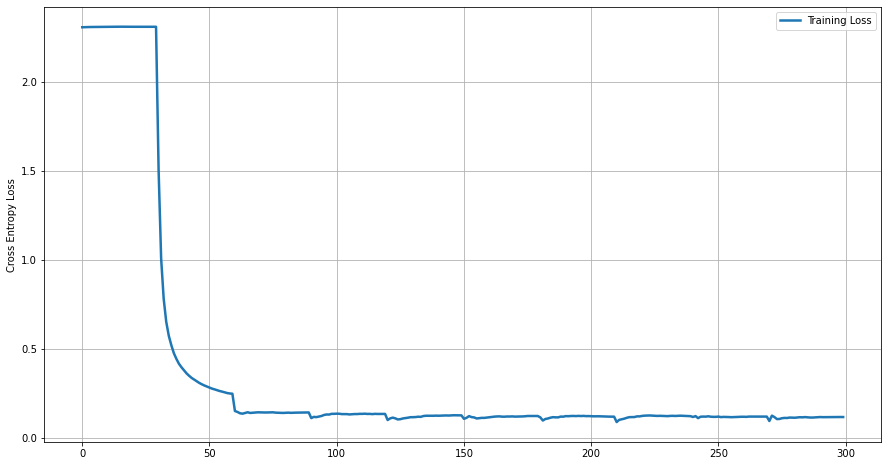

<Figure size 432x288 with 0 Axes>

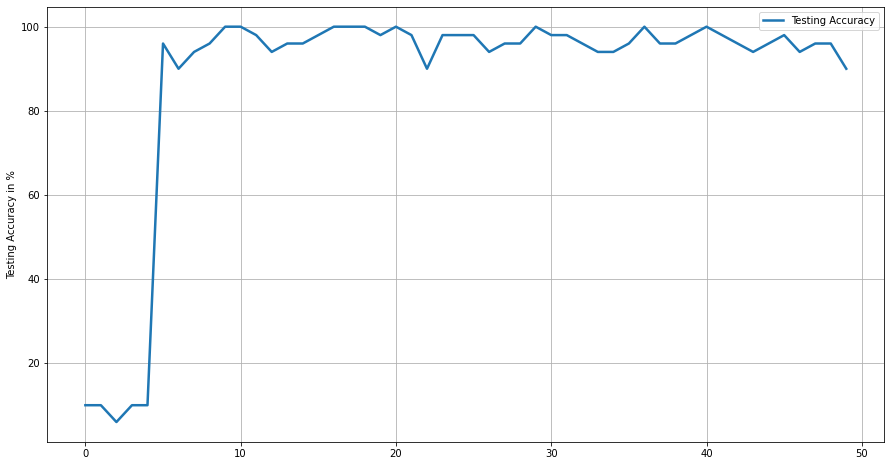

In [10]:
# Download the training and testing data
mini_batch = 50
train_loader = trainload(mini_batch)
test_loader = testload(mini_batch)

# Initialize model
cnn4 = CNN()
if device.type == "cuda":
    cnn4.to('cuda')

# Define loss function
loss_func = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(cnn4.parameters(), lr = 0.01)

# Train the model
num_epochs = 10
train(num_epochs, cnn4, train_loader, test_loader, mini_batch)

### Although all the optimizers perform well for this problem, the SGD optimizer with momentum seems to be the best one as it results 100% accuracy in test data more often than the other optimizers, and also reduces training loss faster than other optimizers. 

# 4. Train the CNN model by changing minibatch size

## a) 1

Epoch [1/10], Step [2000/60000], Loss: 2.4319
Epoch [1/10], Step [4000/60000], Loss: 2.3277
Epoch [1/10], Step [6000/60000], Loss: 2.1940
Epoch [1/10], Step [8000/60000], Loss: 2.2025
Epoch [1/10], Step [10000/60000], Loss: 2.2169
Epoch [1/10], Step [12000/60000], Loss: 2.2702
Epoch [1/10], Step [14000/60000], Loss: 2.3019
Epoch [1/10], Step [16000/60000], Loss: 2.3238
Epoch [1/10], Step [18000/60000], Loss: 2.4865
Epoch [1/10], Step [20000/60000], Loss: 2.3382
Epoch [1/10], Step [22000/60000], Loss: 2.5122
Epoch [1/10], Step [24000/60000], Loss: 2.2803
Epoch [1/10], Step [26000/60000], Loss: 2.1710
Epoch [1/10], Step [28000/60000], Loss: 2.1226
Epoch [1/10], Step [30000/60000], Loss: 2.2989
Epoch [1/10], Step [32000/60000], Loss: 2.2662
Epoch [1/10], Step [34000/60000], Loss: 2.3288
Epoch [1/10], Step [36000/60000], Loss: 2.1783
Epoch [1/10], Step [38000/60000], Loss: 2.2470
Epoch [1/10], Step [40000/60000], Loss: 2.3564
Epoch [1/10], Step [42000/60000], Loss: 2.2707
Epoch [1/10], Ste

Epoch [6/10], Step [46000/60000], Loss: 2.2499
Epoch [6/10], Step [48000/60000], Loss: 2.2861
Epoch [6/10], Step [50000/60000], Loss: 2.1502
Epoch [6/10], Step [52000/60000], Loss: 2.2229
Epoch [6/10], Step [54000/60000], Loss: 2.4115
Epoch [6/10], Step [56000/60000], Loss: 2.2704
Epoch [6/10], Step [58000/60000], Loss: 2.1372
Epoch [6/10], Step [60000/60000], Loss: 2.3025
Epoch Train Time: 167.56 secs
Epoch [7/10], Step [2000/60000], Loss: 2.3928
Epoch [7/10], Step [4000/60000], Loss: 2.4683
Epoch [7/10], Step [6000/60000], Loss: 2.4649
Epoch [7/10], Step [8000/60000], Loss: 2.3880
Epoch [7/10], Step [10000/60000], Loss: 2.2715
Epoch [7/10], Step [12000/60000], Loss: 2.3704
Epoch [7/10], Step [14000/60000], Loss: 2.2414
Epoch [7/10], Step [16000/60000], Loss: 2.3840
Epoch [7/10], Step [18000/60000], Loss: 2.2671
Epoch [7/10], Step [20000/60000], Loss: 2.5047
Epoch [7/10], Step [22000/60000], Loss: 2.5317
Epoch [7/10], Step [24000/60000], Loss: 2.3991
Epoch [7/10], Step [26000/60000], 

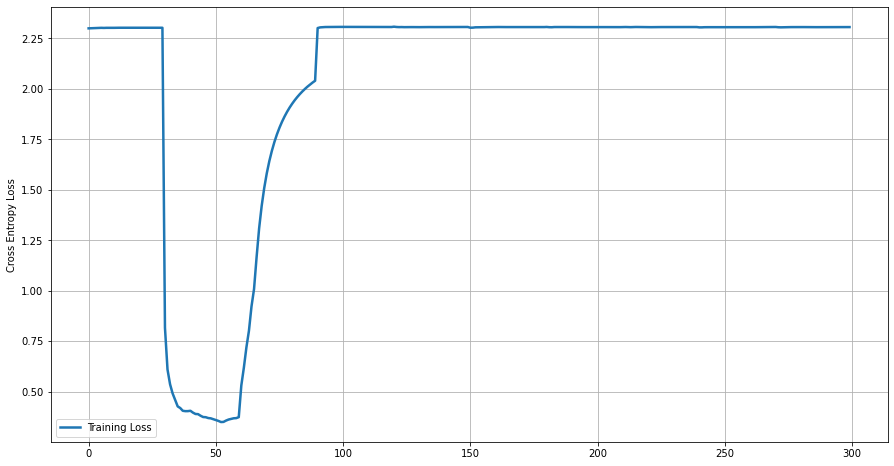

<Figure size 432x288 with 0 Axes>

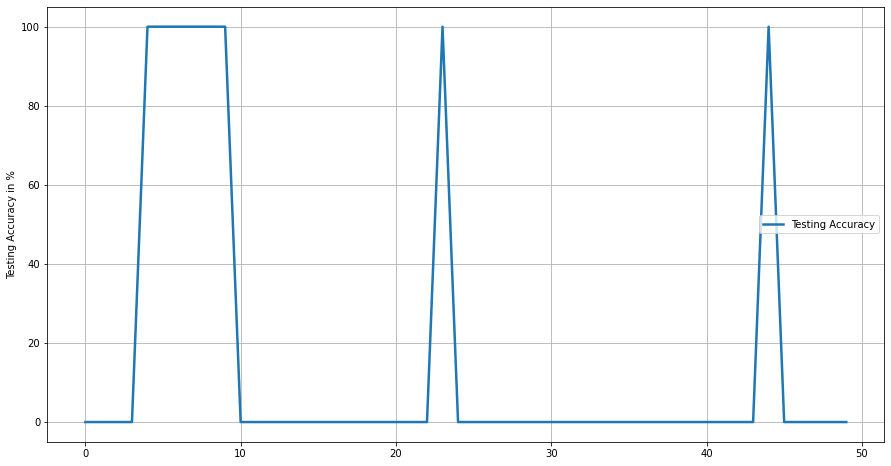

In [11]:
# Download the training and testing data
mini_batch = 1
train_loader = trainload(mini_batch)
test_loader = testload(mini_batch)

# Initialize model
cnn5 = CNN()
if device.type == "cuda":
    cnn5.to('cuda')

# Define loss function
loss_func = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.SGD(cnn5.parameters(), lr = 0.01, momentum = 0.5)

# Train the model
num_epochs = 10
train(num_epochs, cnn5, train_loader, test_loader, mini_batch)

## b) 100

Epoch [1/10], Step [20/600], Loss: 2.2884
Epoch [1/10], Step [40/600], Loss: 2.3170
Epoch [1/10], Step [60/600], Loss: 2.3190
Epoch [1/10], Step [80/600], Loss: 2.3132
Epoch [1/10], Step [100/600], Loss: 2.3291
Epoch [1/10], Step [120/600], Loss: 2.3135
Epoch [1/10], Step [140/600], Loss: 2.3061
Epoch [1/10], Step [160/600], Loss: 2.3295
Epoch [1/10], Step [180/600], Loss: 2.3072
Epoch [1/10], Step [200/600], Loss: 2.3148
Epoch [1/10], Step [220/600], Loss: 2.3055
Epoch [1/10], Step [240/600], Loss: 2.3252
Epoch [1/10], Step [260/600], Loss: 2.3063
Epoch [1/10], Step [280/600], Loss: 2.3202
Epoch [1/10], Step [300/600], Loss: 2.3192
Epoch [1/10], Step [320/600], Loss: 2.3226
Epoch [1/10], Step [340/600], Loss: 2.3080
Epoch [1/10], Step [360/600], Loss: 2.3032
Epoch [1/10], Step [380/600], Loss: 2.3283
Epoch [1/10], Step [400/600], Loss: 2.3128
Epoch [1/10], Step [420/600], Loss: 2.3095
Epoch [1/10], Step [440/600], Loss: 2.3237
Epoch [1/10], Step [460/600], Loss: 2.3002
Epoch [1/10], S

Epoch [7/10], Step [180/600], Loss: 0.0492
Epoch [7/10], Step [200/600], Loss: 0.0585
Epoch [7/10], Step [220/600], Loss: 0.0742
Epoch [7/10], Step [240/600], Loss: 0.0247
Epoch [7/10], Step [260/600], Loss: 0.0479
Epoch [7/10], Step [280/600], Loss: 0.0200
Epoch [7/10], Step [300/600], Loss: 0.0963
Epoch [7/10], Step [320/600], Loss: 0.1000
Epoch [7/10], Step [340/600], Loss: 0.0732
Epoch [7/10], Step [360/600], Loss: 0.0468
Epoch [7/10], Step [380/600], Loss: 0.0225
Epoch [7/10], Step [400/600], Loss: 0.0335
Epoch [7/10], Step [420/600], Loss: 0.0737
Epoch [7/10], Step [440/600], Loss: 0.1202
Epoch [7/10], Step [460/600], Loss: 0.0391
Epoch [7/10], Step [480/600], Loss: 0.0770
Epoch [7/10], Step [500/600], Loss: 0.0231
Epoch [7/10], Step [520/600], Loss: 0.0565
Epoch [7/10], Step [540/600], Loss: 0.0607
Epoch [7/10], Step [560/600], Loss: 0.0487
Epoch [7/10], Step [580/600], Loss: 0.0189
Epoch [7/10], Step [600/600], Loss: 0.0765
Epoch Train Time: 11.35 secs
Epoch [8/10], Step [20/60

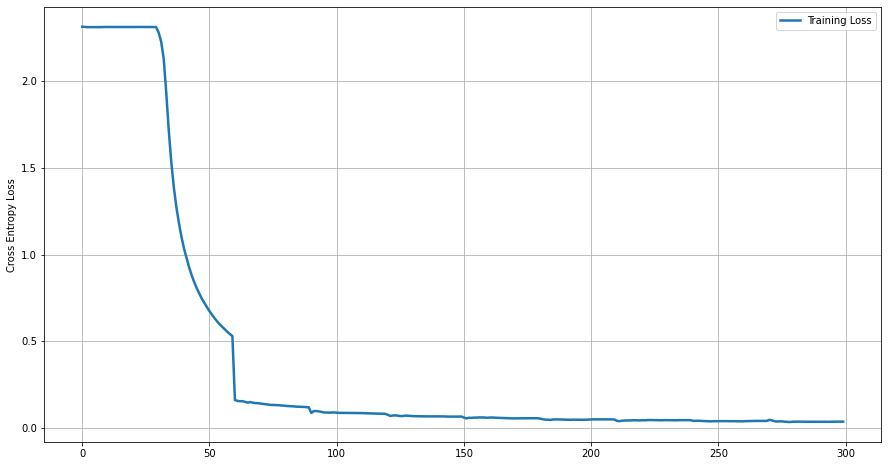

<Figure size 432x288 with 0 Axes>

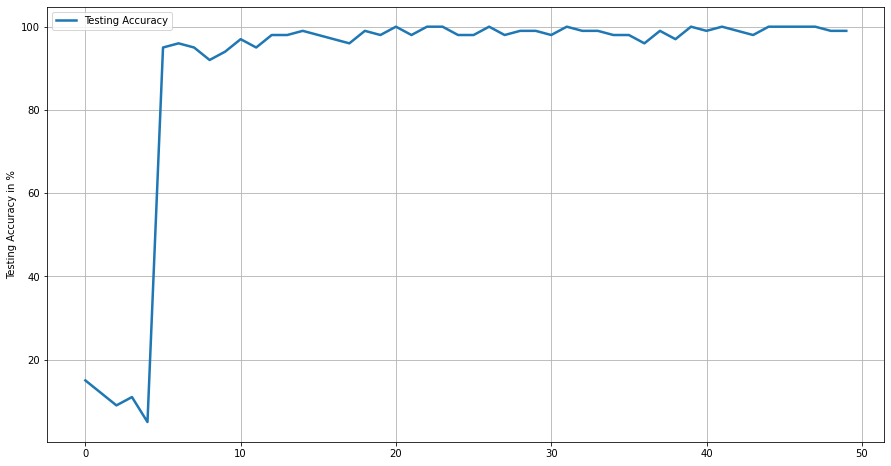

In [12]:
# Download the training and testing data
mini_batch = 100
train_loader = trainload(mini_batch)
test_loader = testload(mini_batch)

# Initialize model
cnn6 = CNN()
if device.type == "cuda":
    cnn6.to('cuda')

# Define loss function
loss_func = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.SGD(cnn6.parameters(), lr = 0.01, momentum = 0.5)

# Train the model
num_epochs = 10
train(num_epochs, cnn6, train_loader, test_loader, mini_batch)

## c) 1000

Epoch [1/10], Step [2/60], Loss: 2.3063
Epoch [1/10], Step [4/60], Loss: 2.3003
Epoch [1/10], Step [6/60], Loss: 2.2997
Epoch [1/10], Step [8/60], Loss: 2.3057
Epoch [1/10], Step [10/60], Loss: 2.3106
Epoch [1/10], Step [12/60], Loss: 2.2984
Epoch [1/10], Step [14/60], Loss: 2.3072
Epoch [1/10], Step [16/60], Loss: 2.3035
Epoch [1/10], Step [18/60], Loss: 2.3018
Epoch [1/10], Step [20/60], Loss: 2.3020
Epoch [1/10], Step [22/60], Loss: 2.3105
Epoch [1/10], Step [24/60], Loss: 2.3069
Epoch [1/10], Step [26/60], Loss: 2.3093
Epoch [1/10], Step [28/60], Loss: 2.3050
Epoch [1/10], Step [30/60], Loss: 2.2999
Epoch [1/10], Step [32/60], Loss: 2.3077
Epoch [1/10], Step [34/60], Loss: 2.3044
Epoch [1/10], Step [36/60], Loss: 2.2997
Epoch [1/10], Step [38/60], Loss: 2.3031
Epoch [1/10], Step [40/60], Loss: 2.3028
Epoch [1/10], Step [42/60], Loss: 2.3096
Epoch [1/10], Step [44/60], Loss: 2.3044
Epoch [1/10], Step [46/60], Loss: 2.3034
Epoch [1/10], Step [48/60], Loss: 2.3111
Epoch [1/10], Step [

Epoch [7/10], Step [36/60], Loss: 0.2223
Epoch [7/10], Step [38/60], Loss: 0.1959
Epoch [7/10], Step [40/60], Loss: 0.2808
Epoch [7/10], Step [42/60], Loss: 0.2271
Epoch [7/10], Step [44/60], Loss: 0.2248
Epoch [7/10], Step [46/60], Loss: 0.2474
Epoch [7/10], Step [48/60], Loss: 0.2267
Epoch [7/10], Step [50/60], Loss: 0.2388
Epoch [7/10], Step [52/60], Loss: 0.2632
Epoch [7/10], Step [54/60], Loss: 0.2516
Epoch [7/10], Step [56/60], Loss: 0.2297
Epoch [7/10], Step [58/60], Loss: 0.2150
Epoch [7/10], Step [60/60], Loss: 0.1991
Epoch Train Time: 10.17 secs
Epoch [8/10], Step [2/60], Loss: 0.2523
Epoch [8/10], Step [4/60], Loss: 0.2095
Epoch [8/10], Step [6/60], Loss: 0.2247
Epoch [8/10], Step [8/60], Loss: 0.2429
Epoch [8/10], Step [10/60], Loss: 0.2290
Epoch [8/10], Step [12/60], Loss: 0.2219
Epoch [8/10], Step [14/60], Loss: 0.2179
Epoch [8/10], Step [16/60], Loss: 0.1987
Epoch [8/10], Step [18/60], Loss: 0.1936
Epoch [8/10], Step [20/60], Loss: 0.1846
Epoch [8/10], Step [22/60], Loss

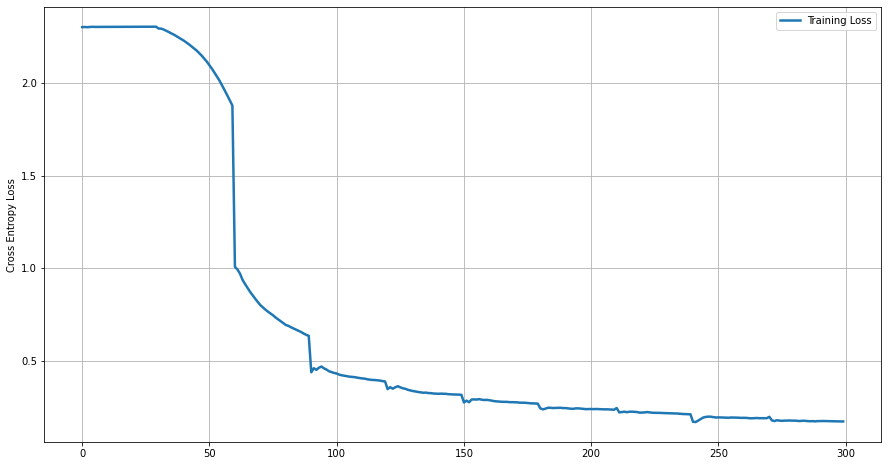

<Figure size 432x288 with 0 Axes>

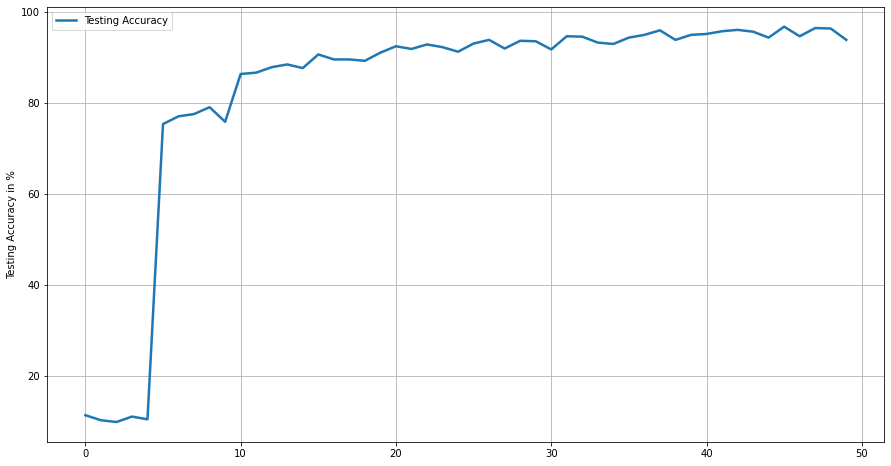

In [13]:
# Download the training and testing data
mini_batch = 1000
train_loader = trainload(mini_batch)
test_loader = testload(mini_batch)

# Initialize model
cnn7 = CNN()
if device.type == "cuda":
    cnn7.to('cuda')
    
# Define loss function
loss_func = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.SGD(cnn7.parameters(), lr = 0.01, momentum = 0.5)

# Train the model
num_epochs = 10
train(num_epochs, cnn7, train_loader, test_loader, mini_batch)

## d) 10000

Epoch [1/10], Step [1/6], Loss: 2.3115
Epoch [1/10], Step [2/6], Loss: 2.3141
Epoch [1/10], Step [3/6], Loss: 2.3124
Epoch [1/10], Step [4/6], Loss: 2.3127
Epoch [1/10], Step [5/6], Loss: 2.3128
Epoch [1/10], Step [6/6], Loss: 2.3114
Epoch Train Time: 8.68 secs
Epoch [2/10], Step [1/6], Loss: 2.3120
Epoch [2/10], Step [2/6], Loss: 2.3089
Epoch [2/10], Step [3/6], Loss: 2.3081
Epoch [2/10], Step [4/6], Loss: 2.3053
Epoch [2/10], Step [5/6], Loss: 2.3011
Epoch [2/10], Step [6/6], Loss: 2.2977
Epoch Train Time: 8.68 secs
Epoch [3/10], Step [1/6], Loss: 2.2951
Epoch [3/10], Step [2/6], Loss: 2.2885
Epoch [3/10], Step [3/6], Loss: 2.2865
Epoch [3/10], Step [4/6], Loss: 2.2822
Epoch [3/10], Step [5/6], Loss: 2.2782
Epoch [3/10], Step [6/6], Loss: 2.2748
Epoch Train Time: 8.73 secs
Epoch [4/10], Step [1/6], Loss: 2.2705
Epoch [4/10], Step [2/6], Loss: 2.2669
Epoch [4/10], Step [3/6], Loss: 2.2599
Epoch [4/10], Step [4/6], Loss: 2.2569
Epoch [4/10], Step [5/6], Loss: 2.2520
Epoch [4/10], Step 

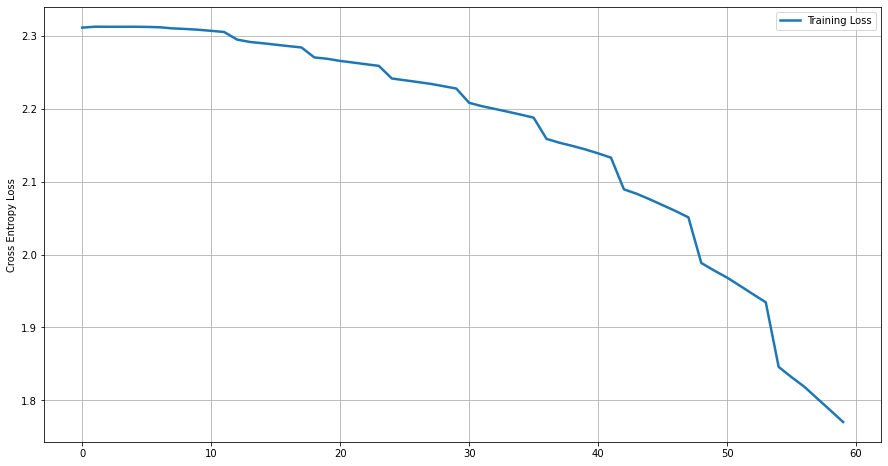

<Figure size 432x288 with 0 Axes>

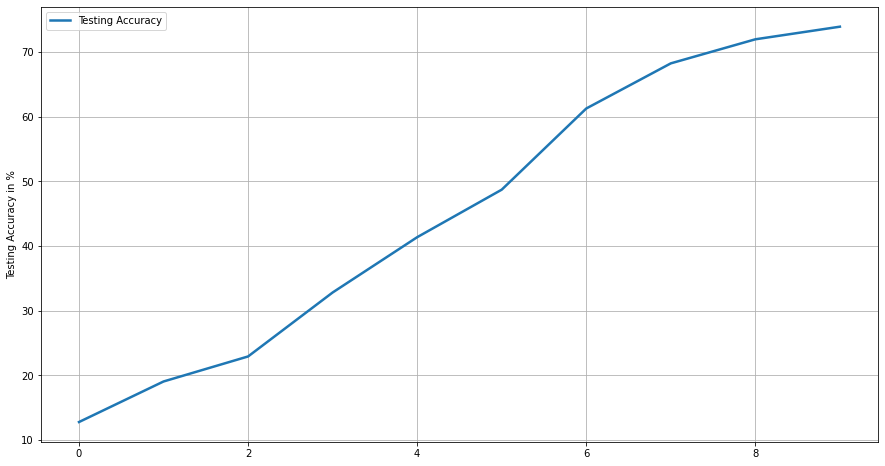

In [14]:
# Download the training and testing data
mini_batch = 10000
train_loader = trainload(mini_batch)
test_loader = testload(mini_batch)

# Initialize model
cnn8 = CNN()
if device.type == "cuda":
    cnn8.to('cuda')
    
# Define loss function
loss_func = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.SGD(cnn8.parameters(), lr = 0.01, momentum = 0.5)

# Train the model
num_epochs = 10
train(num_epochs, cnn8, train_loader, test_loader, mini_batch)

### A very small minibatch_size of 1 takes more time to run and the run time decreases when minibatch_size increases. From the training time printed during training, we notice that training with 1 as minibatch_size takes about 30 minutes to execute. Further, if we increases the minibatch_size to 1000 or 10000, the model doesn't converge in 10 epochs, and hence the training loss is more and testing accuracy is less. 

### Using a minibatch_size of 100 gives the best results, as the testing accuracy is mostly above 95%.

# 5. Train the CNN model by changing learning rate

## a) 0.1

Epoch [1/10], Step [40/1200], Loss: 2.3062
Epoch [1/10], Step [80/1200], Loss: 2.3116
Epoch [1/10], Step [120/1200], Loss: 2.3069
Epoch [1/10], Step [160/1200], Loss: 2.3286
Epoch [1/10], Step [200/1200], Loss: 2.3079
Epoch [1/10], Step [240/1200], Loss: 2.3235
Epoch [1/10], Step [280/1200], Loss: 2.3070
Epoch [1/10], Step [320/1200], Loss: 2.3079
Epoch [1/10], Step [360/1200], Loss: 2.3036
Epoch [1/10], Step [400/1200], Loss: 2.3019
Epoch [1/10], Step [440/1200], Loss: 2.2949
Epoch [1/10], Step [480/1200], Loss: 2.3045
Epoch [1/10], Step [520/1200], Loss: 2.2907
Epoch [1/10], Step [560/1200], Loss: 2.3349
Epoch [1/10], Step [600/1200], Loss: 2.3128
Epoch [1/10], Step [640/1200], Loss: 2.3030
Epoch [1/10], Step [680/1200], Loss: 2.3054
Epoch [1/10], Step [720/1200], Loss: 2.3074
Epoch [1/10], Step [760/1200], Loss: 2.3084
Epoch [1/10], Step [800/1200], Loss: 2.2809
Epoch [1/10], Step [840/1200], Loss: 2.3059
Epoch [1/10], Step [880/1200], Loss: 2.3212
Epoch [1/10], Step [920/1200], Los

Epoch [7/10], Step [120/1200], Loss: 0.0081
Epoch [7/10], Step [160/1200], Loss: 0.0027
Epoch [7/10], Step [200/1200], Loss: 0.0360
Epoch [7/10], Step [240/1200], Loss: 0.0725
Epoch [7/10], Step [280/1200], Loss: 0.0014
Epoch [7/10], Step [320/1200], Loss: 0.0091
Epoch [7/10], Step [360/1200], Loss: 0.2364
Epoch [7/10], Step [400/1200], Loss: 0.0057
Epoch [7/10], Step [440/1200], Loss: 0.0005
Epoch [7/10], Step [480/1200], Loss: 0.0034
Epoch [7/10], Step [520/1200], Loss: 0.0046
Epoch [7/10], Step [560/1200], Loss: 0.0097
Epoch [7/10], Step [600/1200], Loss: 0.0075
Epoch [7/10], Step [640/1200], Loss: 0.0051
Epoch [7/10], Step [680/1200], Loss: 0.0595
Epoch [7/10], Step [720/1200], Loss: 0.0048
Epoch [7/10], Step [760/1200], Loss: 0.0004
Epoch [7/10], Step [800/1200], Loss: 0.0019
Epoch [7/10], Step [840/1200], Loss: 0.0952
Epoch [7/10], Step [880/1200], Loss: 0.0607
Epoch [7/10], Step [920/1200], Loss: 0.0144
Epoch [7/10], Step [960/1200], Loss: 0.0898
Epoch [7/10], Step [1000/1200], 

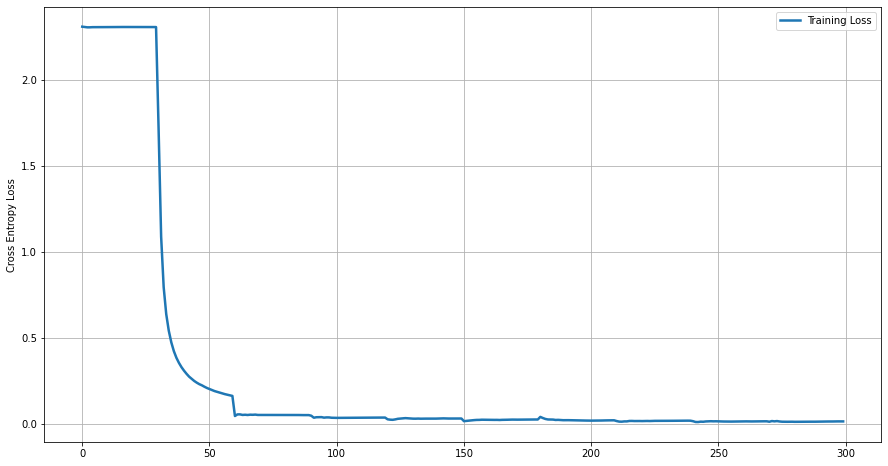

<Figure size 432x288 with 0 Axes>

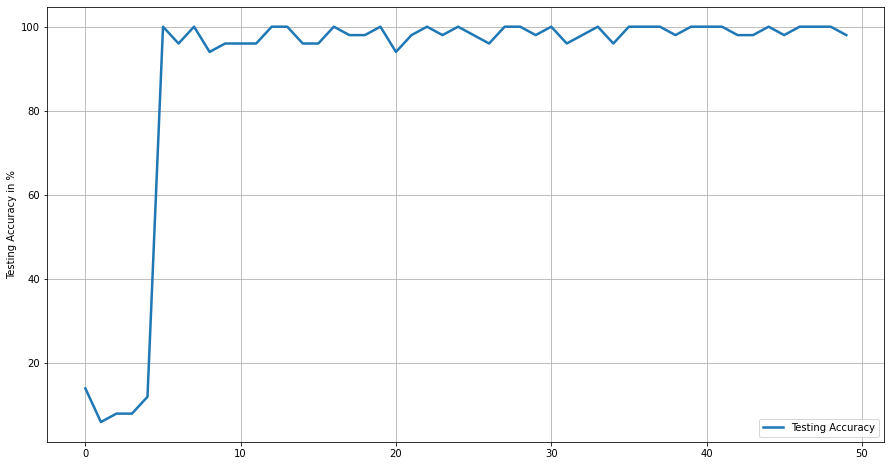

In [15]:
# Download the training and testing data
mini_batch = 50
train_loader = trainload(mini_batch)
test_loader = testload(mini_batch)

# Initialize model
cnn9 = CNN()
if device.type == "cuda":
    cnn9.to('cuda')

# Define loss function
loss_func = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.SGD(cnn9.parameters(), lr = 0.1, momentum = 0.5)

# Train the model
num_epochs = 10
train(num_epochs, cnn9, train_loader, test_loader, mini_batch)

## b) 0.01

Epoch [1/10], Step [40/1200], Loss: 2.3202
Epoch [1/10], Step [80/1200], Loss: 2.3064
Epoch [1/10], Step [120/1200], Loss: 2.3114
Epoch [1/10], Step [160/1200], Loss: 2.3028
Epoch [1/10], Step [200/1200], Loss: 2.2963
Epoch [1/10], Step [240/1200], Loss: 2.2976
Epoch [1/10], Step [280/1200], Loss: 2.3488
Epoch [1/10], Step [320/1200], Loss: 2.3267
Epoch [1/10], Step [360/1200], Loss: 2.3238
Epoch [1/10], Step [400/1200], Loss: 2.3193
Epoch [1/10], Step [440/1200], Loss: 2.3186
Epoch [1/10], Step [480/1200], Loss: 2.3162
Epoch [1/10], Step [520/1200], Loss: 2.3309
Epoch [1/10], Step [560/1200], Loss: 2.2968
Epoch [1/10], Step [600/1200], Loss: 2.3220
Epoch [1/10], Step [640/1200], Loss: 2.3072
Epoch [1/10], Step [680/1200], Loss: 2.3144
Epoch [1/10], Step [720/1200], Loss: 2.3160
Epoch [1/10], Step [760/1200], Loss: 2.3031
Epoch [1/10], Step [800/1200], Loss: 2.3095
Epoch [1/10], Step [840/1200], Loss: 2.3153
Epoch [1/10], Step [880/1200], Loss: 2.3252
Epoch [1/10], Step [920/1200], Los

Epoch [7/10], Step [120/1200], Loss: 0.1413
Epoch [7/10], Step [160/1200], Loss: 0.0624
Epoch [7/10], Step [200/1200], Loss: 0.0289
Epoch [7/10], Step [240/1200], Loss: 0.0054
Epoch [7/10], Step [280/1200], Loss: 0.1315
Epoch [7/10], Step [320/1200], Loss: 0.0058
Epoch [7/10], Step [360/1200], Loss: 0.0504
Epoch [7/10], Step [400/1200], Loss: 0.0099
Epoch [7/10], Step [440/1200], Loss: 0.0206
Epoch [7/10], Step [480/1200], Loss: 0.0384
Epoch [7/10], Step [520/1200], Loss: 0.0389
Epoch [7/10], Step [560/1200], Loss: 0.0023
Epoch [7/10], Step [600/1200], Loss: 0.0355
Epoch [7/10], Step [640/1200], Loss: 0.0123
Epoch [7/10], Step [680/1200], Loss: 0.0113
Epoch [7/10], Step [720/1200], Loss: 0.0122
Epoch [7/10], Step [760/1200], Loss: 0.0466
Epoch [7/10], Step [800/1200], Loss: 0.0053
Epoch [7/10], Step [840/1200], Loss: 0.0448
Epoch [7/10], Step [880/1200], Loss: 0.0249
Epoch [7/10], Step [920/1200], Loss: 0.0018
Epoch [7/10], Step [960/1200], Loss: 0.0895
Epoch [7/10], Step [1000/1200], 

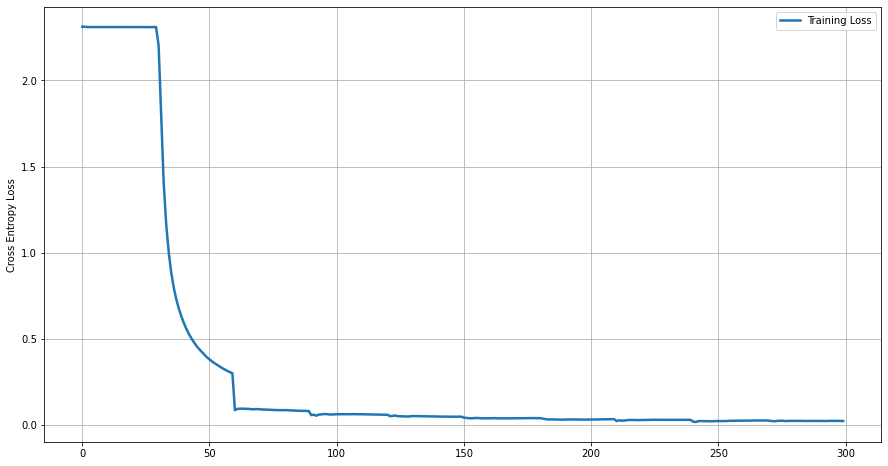

<Figure size 432x288 with 0 Axes>

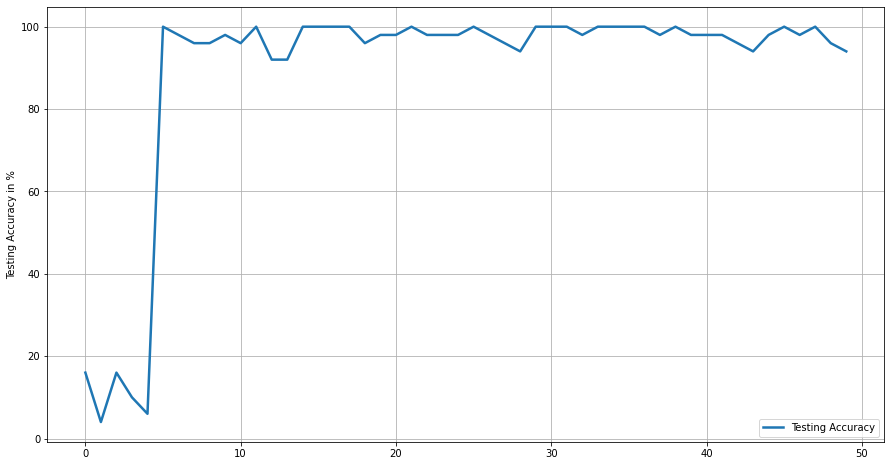

In [16]:
# Download the training and testing data
mini_batch = 50
train_loader = trainload(mini_batch)
test_loader = testload(mini_batch)

# Initialize model
cnn10 = CNN()
if device.type == "cuda":
    cnn10.to('cuda')

# Define loss function
loss_func = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.SGD(cnn10.parameters(), lr = 0.01, momentum = 0.5)

# Train the model
num_epochs = 10
train(num_epochs, cnn10, train_loader, test_loader, mini_batch)

## c) 0.001

Epoch [1/10], Step [40/1200], Loss: 2.3321
Epoch [1/10], Step [80/1200], Loss: 2.3130
Epoch [1/10], Step [120/1200], Loss: 2.3247
Epoch [1/10], Step [160/1200], Loss: 2.3344
Epoch [1/10], Step [200/1200], Loss: 2.3088
Epoch [1/10], Step [240/1200], Loss: 2.3253
Epoch [1/10], Step [280/1200], Loss: 2.3112
Epoch [1/10], Step [320/1200], Loss: 2.3514
Epoch [1/10], Step [360/1200], Loss: 2.2886
Epoch [1/10], Step [400/1200], Loss: 2.3263
Epoch [1/10], Step [440/1200], Loss: 2.3017
Epoch [1/10], Step [480/1200], Loss: 2.3129
Epoch [1/10], Step [520/1200], Loss: 2.3158
Epoch [1/10], Step [560/1200], Loss: 2.3258
Epoch [1/10], Step [600/1200], Loss: 2.3302
Epoch [1/10], Step [640/1200], Loss: 2.3216
Epoch [1/10], Step [680/1200], Loss: 2.3180
Epoch [1/10], Step [720/1200], Loss: 2.3178
Epoch [1/10], Step [760/1200], Loss: 2.3238
Epoch [1/10], Step [800/1200], Loss: 2.3294
Epoch [1/10], Step [840/1200], Loss: 2.3036
Epoch [1/10], Step [880/1200], Loss: 2.2912
Epoch [1/10], Step [920/1200], Los

Epoch [7/10], Step [120/1200], Loss: 1.2102
Epoch [7/10], Step [160/1200], Loss: 1.2964
Epoch [7/10], Step [200/1200], Loss: 1.3761
Epoch [7/10], Step [240/1200], Loss: 1.1337
Epoch [7/10], Step [280/1200], Loss: 1.3227
Epoch [7/10], Step [320/1200], Loss: 1.0585
Epoch [7/10], Step [360/1200], Loss: 1.1522
Epoch [7/10], Step [400/1200], Loss: 1.2100
Epoch [7/10], Step [440/1200], Loss: 1.1973
Epoch [7/10], Step [480/1200], Loss: 1.1753
Epoch [7/10], Step [520/1200], Loss: 1.2553
Epoch [7/10], Step [560/1200], Loss: 1.1737
Epoch [7/10], Step [600/1200], Loss: 1.0825
Epoch [7/10], Step [640/1200], Loss: 1.1439
Epoch [7/10], Step [680/1200], Loss: 0.9656
Epoch [7/10], Step [720/1200], Loss: 1.0846
Epoch [7/10], Step [760/1200], Loss: 0.9715
Epoch [7/10], Step [800/1200], Loss: 0.9732
Epoch [7/10], Step [840/1200], Loss: 0.8814
Epoch [7/10], Step [880/1200], Loss: 1.0575
Epoch [7/10], Step [920/1200], Loss: 0.9863
Epoch [7/10], Step [960/1200], Loss: 1.0065
Epoch [7/10], Step [1000/1200], 

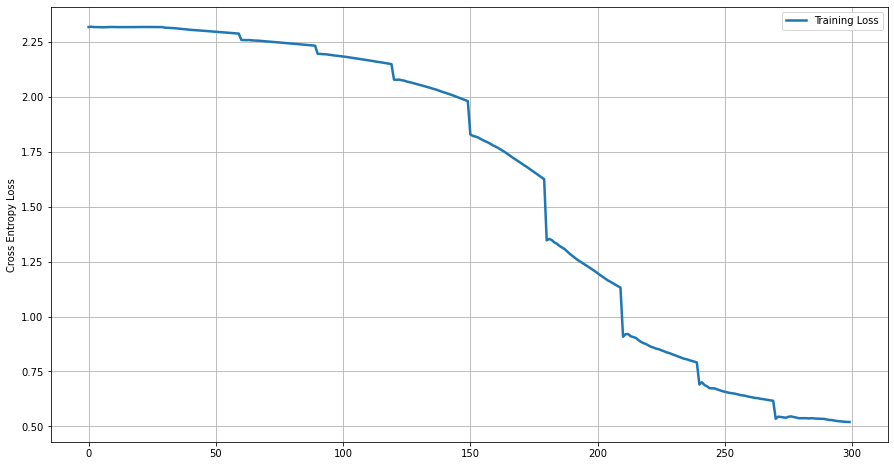

<Figure size 432x288 with 0 Axes>

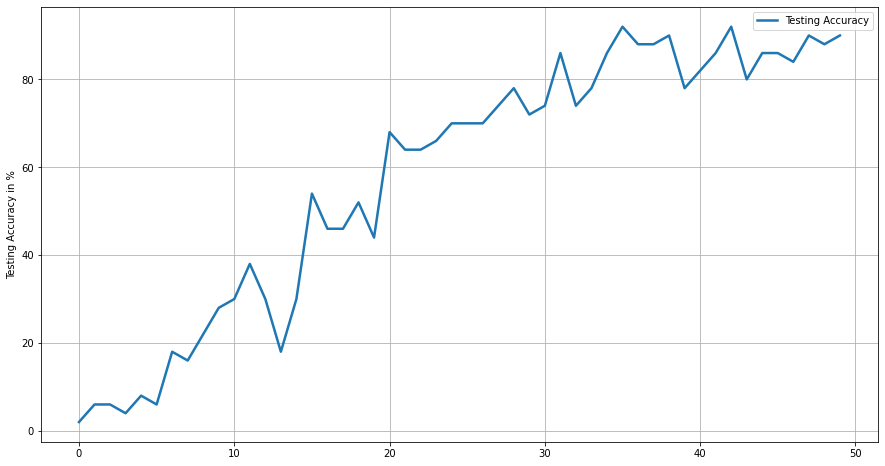

In [17]:
# Download the training and testing data
mini_batch = 50
train_loader = trainload(mini_batch)
test_loader = testload(mini_batch)

# Initialize model
cnn11 = CNN()
if device.type == "cuda":
    cnn11.to('cuda')

# Define loss function
loss_func = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.SGD(cnn11.parameters(), lr = 0.0001, momentum = 0.5)

# Train the model
num_epochs = 10
train(num_epochs, cnn11, train_loader, test_loader, mini_batch)

## d) 0.0001

Epoch [1/10], Step [40/1200], Loss: 2.2902
Epoch [1/10], Step [80/1200], Loss: 2.3030
Epoch [1/10], Step [120/1200], Loss: 2.3008
Epoch [1/10], Step [160/1200], Loss: 2.3023
Epoch [1/10], Step [200/1200], Loss: 2.3061
Epoch [1/10], Step [240/1200], Loss: 2.3134
Epoch [1/10], Step [280/1200], Loss: 2.2959
Epoch [1/10], Step [320/1200], Loss: 2.3210
Epoch [1/10], Step [360/1200], Loss: 2.2790
Epoch [1/10], Step [400/1200], Loss: 2.3073
Epoch [1/10], Step [440/1200], Loss: 2.3021
Epoch [1/10], Step [480/1200], Loss: 2.2983
Epoch [1/10], Step [520/1200], Loss: 2.2863
Epoch [1/10], Step [560/1200], Loss: 2.3125
Epoch [1/10], Step [600/1200], Loss: 2.2982
Epoch [1/10], Step [640/1200], Loss: 2.3127
Epoch [1/10], Step [680/1200], Loss: 2.3105
Epoch [1/10], Step [720/1200], Loss: 2.2871
Epoch [1/10], Step [760/1200], Loss: 2.3234
Epoch [1/10], Step [800/1200], Loss: 2.2926
Epoch [1/10], Step [840/1200], Loss: 2.3067
Epoch [1/10], Step [880/1200], Loss: 2.3179
Epoch [1/10], Step [920/1200], Los

Epoch [7/10], Step [120/1200], Loss: 0.9554
Epoch [7/10], Step [160/1200], Loss: 1.0210
Epoch [7/10], Step [200/1200], Loss: 0.9011
Epoch [7/10], Step [240/1200], Loss: 0.9585
Epoch [7/10], Step [280/1200], Loss: 0.8423
Epoch [7/10], Step [320/1200], Loss: 0.7891
Epoch [7/10], Step [360/1200], Loss: 0.8425
Epoch [7/10], Step [400/1200], Loss: 0.9811
Epoch [7/10], Step [440/1200], Loss: 0.8274
Epoch [7/10], Step [480/1200], Loss: 0.8966
Epoch [7/10], Step [520/1200], Loss: 0.7602
Epoch [7/10], Step [560/1200], Loss: 0.9119
Epoch [7/10], Step [600/1200], Loss: 0.7615
Epoch [7/10], Step [640/1200], Loss: 0.7727
Epoch [7/10], Step [680/1200], Loss: 0.7805
Epoch [7/10], Step [720/1200], Loss: 0.9338
Epoch [7/10], Step [760/1200], Loss: 0.8897
Epoch [7/10], Step [800/1200], Loss: 0.9376
Epoch [7/10], Step [840/1200], Loss: 0.7056
Epoch [7/10], Step [880/1200], Loss: 0.8411
Epoch [7/10], Step [920/1200], Loss: 0.6377
Epoch [7/10], Step [960/1200], Loss: 0.8782
Epoch [7/10], Step [1000/1200], 

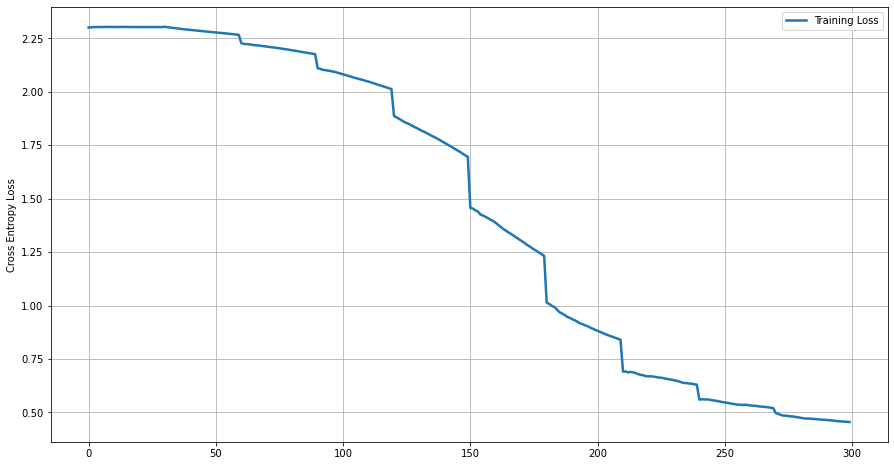

<Figure size 432x288 with 0 Axes>

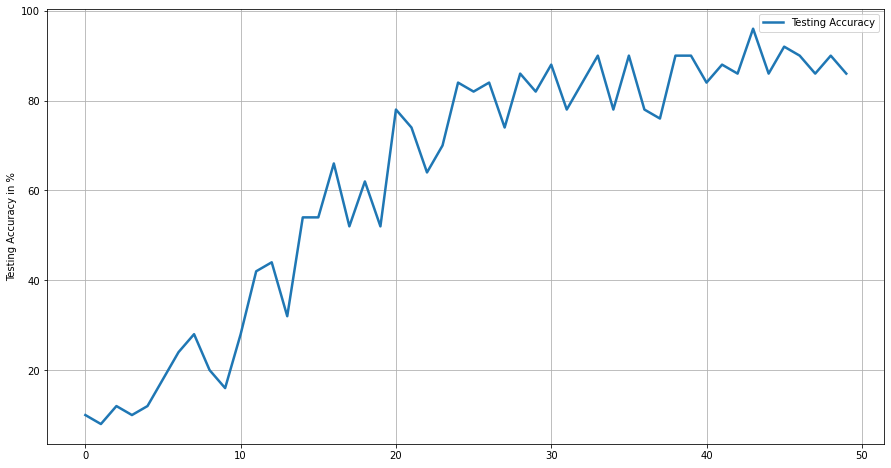

In [18]:
# Download the training and testing data
mini_batch = 50
train_loader = trainload(mini_batch)
test_loader = testload(mini_batch)

# Initialize model
cnn12 = CNN()
if device.type == "cuda":
    cnn12.to('cuda')

# Define loss function
loss_func = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.SGD(cnn12.parameters(), lr = 0.0001, momentum = 0.5)

# Train the model
num_epochs = 10
train(num_epochs, cnn12, train_loader, test_loader, mini_batch)

### The model fails to converge when the learning rate is 0.001 and 0.0001, and will need more epochs to converge. Learning rate 0.1 and 0.01 show similar results with almost similar training time after multiple trails. Hence, both 0.1 and 0.01 are the best learning rates.